In [1]:
import os
import numpy as np
import pydicom
import SimpleITK as sitk
from radiomics import featureextractor
from pathlib import Path

In [2]:
def load_rtstruct(rtstruct_path):
    """Load the RTSTRUCT DICOM file."""
    rtstruct = pydicom.dcmread(rtstruct_path)
    return rtstruct

In [3]:
def extract_contours(rtstruct, roi_name):
    """Extract 2D contours for a specific ROI (e.g., GTV)."""
    for roi, contour in zip(rtstruct.StructureSetROISequence, rtstruct.ROIContourSequence):
        if roi.ROIName == roi_name:
            print(f"Found ROI: {roi_name}")
            contours = []
            for contour_sequence in contour.ContourSequence:
                contour_data = contour_sequence.ContourData
                points = np.array(contour_data).reshape(-1, 3)  # Convert to (x, y, z)
                contours.append(points)
            return contours
    raise ValueError(f"ROI '{roi_name}' not found in RTSTRUCT file.")

In [4]:
def create_mask_from_contours(contours, ct_image):
    """Convert 2D contours into a 3D binary mask aligned with the CT scan."""
    # Get metadata from the CT image
    origin = np.array(ct_image.GetOrigin())  
    spacing = np.array(ct_image.GetSpacing())  
    direction = np.array(ct_image.GetDirection()).reshape(3, 3)  

    # Initialize the mask
    mask_shape = sitk.GetArrayFromImage(ct_image).shape
    mask = np.zeros(mask_shape, dtype=np.uint8)

    for points in contours:
        for point in points:
            # Convert physical coordinates to voxel indices
            physical_point = np.array(point)
            voxel_indices = np.round(np.linalg.inv(direction).dot((physical_point - origin) / spacing)).astype(int)
            
            # Convert to (z, y, x) for mask indexing
            x, y, z = voxel_indices
            # if 0 <= z < mask.shape[0] and 0 <= y < mask.shape[1] and 0 <= x < mask.shape[2]:
            mask[z, y, x] = 1  # Assign 1 to points within the contour

    # Convert the mask to a SimpleITK image and inherit metadata from the CT image
    mask_image = sitk.GetImageFromArray(mask)
    mask_image.SetOrigin(ct_image.GetOrigin())
    mask_image.SetSpacing(ct_image.GetSpacing())
    mask_image.SetDirection(ct_image.GetDirection())

    return mask_image


In [5]:
def extract_radiomics_features(ct_path, mask):
    """Extract radiomics features using pyradiomics."""
    # Convert CT and mask to NIfTI for pyradiomics compatibility
    ct_image = sitk.ReadImage(ct_path)
    mask_path = os.path.join(Path(ct_path).parent,"binary_mask.nii.gz")
    sitk.WriteImage(mask, mask_path)

    # Initialize pyradiomics extractor with specific feature categories
    features_name = {
        'firstorder': {},
        'shape': {},
        'glcm': {},
        'glrlm': {},
        'glszm': {},
        'gldm': {},
    }
    
    imageTypeSettings = {
        'Original': {},              
        'Wavelet': {},               
        'LoG': {'sigma': [1, 3, 5]},
        'Gradient': {},
    }
    
    extractor = featureextractor.RadiomicsFeatureExtractor(additionalInfo=True)
    # extractor.enableAllFeatures()
    extractor.enableImageTypes(**imageTypeSettings)
    extractor.enableFeaturesByName(**features_name)
    # extractor.imageTypeSettings = imageTypeSettings

    # Set GLCM symmetry configuration
    # extractor.settings['symmetricalGLCM'] = True

    # Extract features
    features = extractor.execute(ct_path, mask_path)

    # Filter features to ensure at least 300 are extracted
    feature_dict = {key: value for key, value in features.items() if not key.startswith("diagnostics")}
    # if len(feature_dict) < 300:
    #     raise ValueError(f"Insufficient features extracted: {len(feature_dict)}. Ensure the CT and mask are properly aligned.")

    # # Print extracted features
    # for key, value in feature_dict.items():
    #     print(f"{key}: {value}")

    return feature_dict

In [6]:
# Input paths
rtstruct_path = "../data/manifest-1603198545583/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/3.000000-NA-78236/1-1.dcm"  
ct_series_path = '../data/manifest-1603198545583/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046'
ct_path = os.path.join(Path(ct_series_path).parent, "CT_image.nii.gz")
roi_name = "GTV-1"

In [7]:
reader = sitk.ImageSeriesReader()
dicom_files = reader.GetGDCMSeriesFileNames(ct_series_path)
reader.SetFileNames(dicom_files)
image = reader.Execute()
sitk.WriteImage(image, ct_path)

In [109]:
# Load RTSTRUCT file
print("Loading RTSTRUCT file...")
rtstruct = load_rtstruct(rtstruct_path)
print("Extracting contours...")
contours = extract_contours(rtstruct, roi_name)
print("Loading CT image...")
ct_image = sitk.ReadImage(ct_path)
print("Creating binary mask...")
mask = create_mask_from_contours(contours, ct_image)
print("Extracting radiomics features...")
features = extract_radiomics_features(ct_path, mask)

Loading RTSTRUCT file...
Extracting contours...
Found ROI: GTV-1
Loading CT image...
Creating binary mask...
Extracting radiomics features...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [130]:
for k,v in features.items():
    if isinstance(v, np.ndarray):
        if v.size == 1:
            pass
        else:
            print(k,v)

In [84]:
mask_array = sitk.GetArrayFromImage(mask)
roi_size = np.sum(mask_array)
print(f"ROI size (in voxels): {roi_size}")

if roi_size == 0:
    raise ValueError("The ROI is empty. Ensure the mask correctly segments the region of interest.")


ROI size (in voxels): 2484


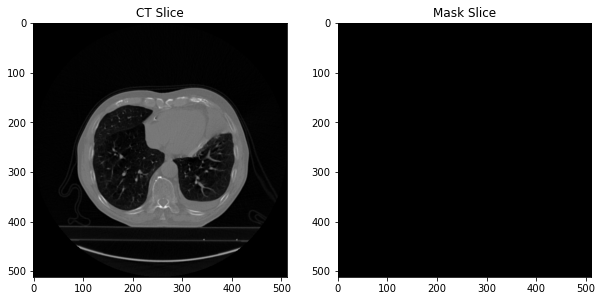

In [85]:
import matplotlib.pyplot as plt

# Visualize one slice
ct_array = sitk.GetArrayFromImage(ct_image)
mask_array = sitk.GetArrayFromImage(mask)
slice_idx = 50  # Middle slice

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("CT Slice")
plt.imshow(ct_array[slice_idx, :, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Mask Slice")
plt.imshow(mask_array[slice_idx, :, :], cmap="gray")
plt.show()


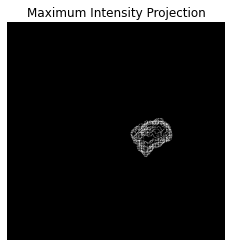

In [87]:
# Maximum intensity projection along the Z-axis
ct_array = sitk.GetArrayFromImage(mask)
mip_2d = np.max(ct_array, axis=0)

# Display the MIP
plt.imshow(mip_2d, cmap="gray")
plt.title("Maximum Intensity Projection")
plt.axis("off")
plt.show()

In [12]:
import glob
import re
patient_dirs = glob.glob('../data/manifest-1603198545583/NSCLC-Radiomics/*/')
file_list = glob.glob(f"{patient_dirs[346]}/*/*")
file_list_sorted = sorted(
    [file for file in file_list if (file.split('/')[-1][0].isdigit()) and not (re.search('Segmentation',file))],
    key=lambda x: float(x.split('/')[-1].split('.')[0])
)
ct_series_path = file_list_sorted[0]
rtstruct_path = glob.glob(f"{file_list_sorted[1]}/*")[0]
ct_path = os.path.join(Path(ct_series_path).parent, "CT_image.nii.gz")
feature_path = os.path.join(Path(ct_series_path).parent, "CT_features.joblib")

In [ ]:
rtstruct = load_rtstruct(rtstruct_path)

In [10]:
for i in rtstruct.StructureSetROISequence:
    print(i.ROIName)

gtv-2
Lungs-Total
Esophagus
Spinal-Cord
GTV-1


In [11]:
roi_name = "GTV-1"
contours = extract_contours(rtstruct, roi_name)

Found ROI: GTV-1
